This notebook is for trying the hypothesis of clustering and PCA for data anlaysis

In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

1. Load mesh elements data
2. For each cell load:
    1. Strain (perhaps might be rather noisy, let's see)
        1. area strain
        2. fibre strain
    2. XYZ position coordinates (to encourage grouping of close together cells)

POA
1. First, try doing a PCA based only on the strains. How can we separate groups?
2. Then augment this by adding the XYZ coordaintes to the features. This should encourage spatially close pionts to be near each other in PCA-space.
3. For both, look at the points in PCA-space.
    1. How many distinct clusters do there appear to be?
    2. Are there any outliers?

### Load Mesh

In [2]:
path2msh="/home/csi20local/Dropbox/phd/Data/RG_CT_Cases/CT-CRT/case05/MT-HiRes/SW-0.0-BE-1e-9/cLr-fibres-aligned-4.vtp"

msh=pv.read(path2msh)

### LA Body Condition

In [3]:
condition = msh.cell_data["region_v2"]!=0

### Set up feature Matrix X_func

In [4]:
func_features_list=[f'endo_{i}-f1_strains' for i in range(1,8)]
func_features_list.append('endo_avg-f1_strains')
func_features_list.append('area-strains')

In [5]:
# msh_cell_centers=msh.cell_centers()

In [6]:
X_func=np.zeros((msh.n_cells, len(func_features_list)))

for i in range(X_func.shape[1]):
    X_func[:, i]=msh.cell_data[func_features_list[i]]

In [7]:
condition.shape

(199282,)

In [8]:
X_func.shape

(199282, 9)

### Filter based upon LA body label

In [9]:
X_func_LAbody=X_func[condition, :]

### Do PCA on Func Data 

In [10]:
## find number of dims to capture 95% of variance in functional strains 
pca = PCA()
pca.fit(X_func_LAbody)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

7

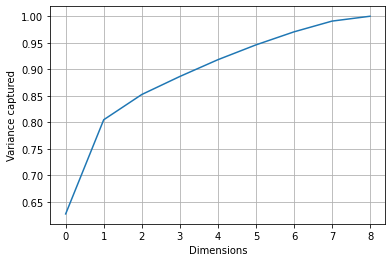

In [11]:
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Variance captured")
plt.grid(True)

In [12]:
pca = PCA(n_components = d)
X_func_LAbody_fit = pca.fit_transform(X_func_LAbody)

In [13]:
pca.explained_variance_ratio_

array([0.62745415, 0.17744729, 0.04758269, 0.03397843, 0.03160386,
       0.02793225, 0.02457022])

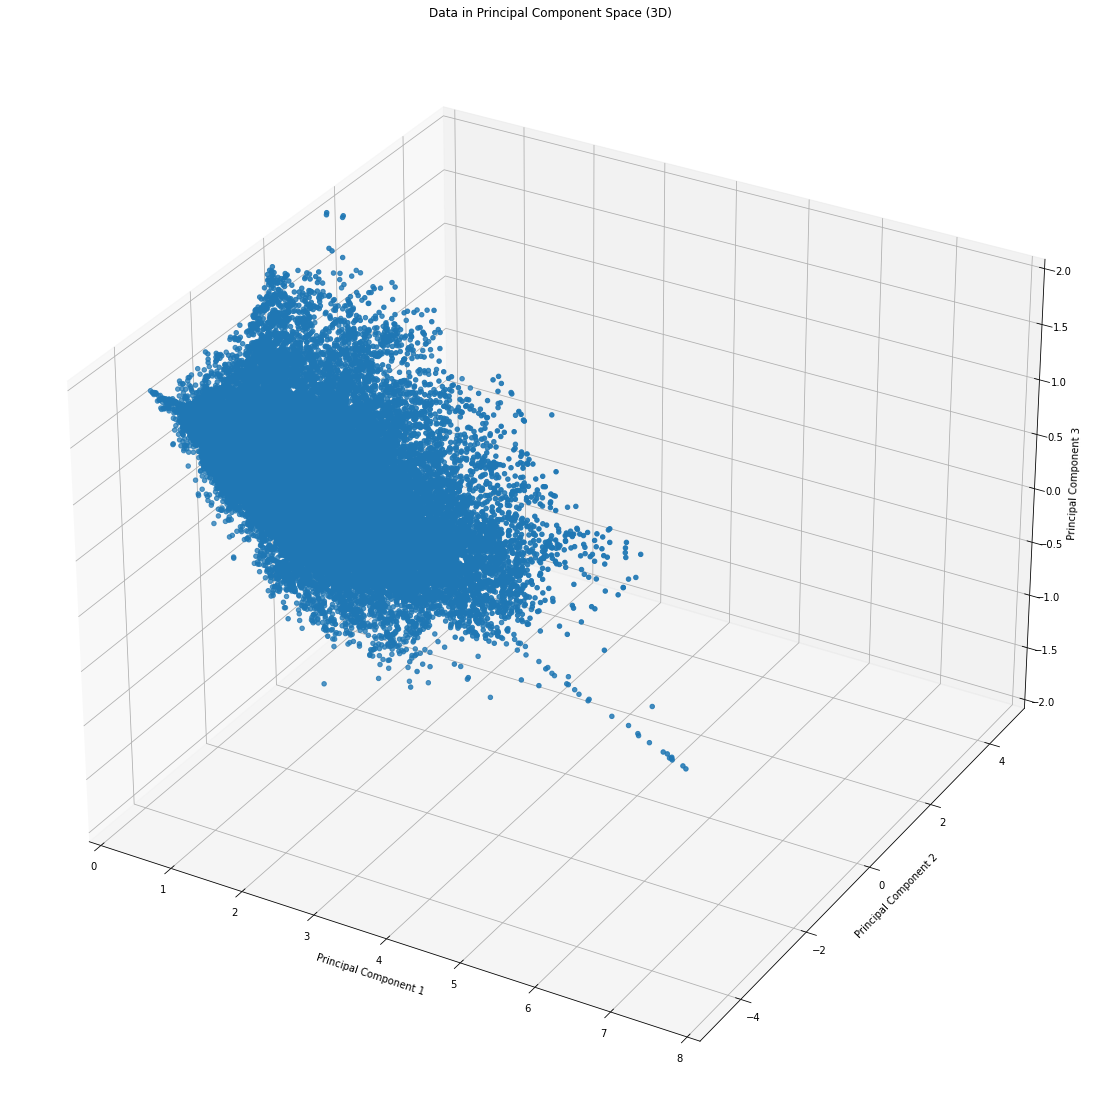

In [34]:
# Create a 3D scatter plot of the principal components
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_func_LAbody_fit[:, 0], X_func_LAbody_fit[:, 1], X_func_LAbody_fit[:, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')

ax.set_xlim(0,8)
ax.set_ylim(-5,5)
ax.set_zlim(-2,2)
plt.show()

In [20]:
cond_outlier=X_func_LAbody_fit[:, 1] > 100
np.sum(cond_outlier)

1

(array([4.50500e+03, 1.28744e+05, 7.78000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

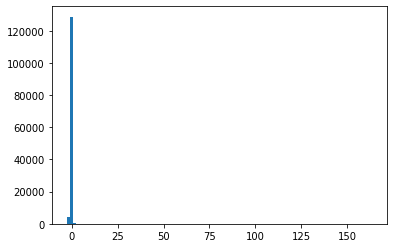

In [23]:
plt.hist(X_func_LAbody_fit[:, 1], bins=100)

### Augment features to include Cell Centre XYZ Positions

In [121]:
path2cell_centres="/home/csi20local/Dropbox/phd/Data/RG_CT_Cases/CT-CRT/case05/MT-HiRes/SW-0.0-BE-1e-9/cLr-fibres-aligned-4-cell-centres.txt"

In [122]:
df=pd.read_csv(path2cell_centres, skiprows=2, names=["Point", "idx", "X", "Y", "Z"], sep=' ')
df=df.drop(labels=["Point", "idx"], axis=1)
df.head()

,X,Y,Z
0,-9.30811,-150.737,76.1263
1,-11.47750,-153.726,75.6220
2,-11.40920,-153.646,75.6119
3,-10.28570,-151.971,75.6863
4,-10.38120,-152.080,75.6604


In [123]:
cell_centres=df.to_numpy()
cell_centres.shape

(199282, 3)

In [124]:
X_func.shape

(199282, 9)

In [125]:
X_func_pos=np.concatenate((X_func, cell_centres), axis=1)
X_func_pos_LAbody=X_func_pos[condition]

### Re-do PCA using Combination of Func & Positional Data

In [126]:
## find number of dims to capture 95% of variance in functional strains 
pca = PCA()
pca.fit(X_func_pos_LAbody)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

3

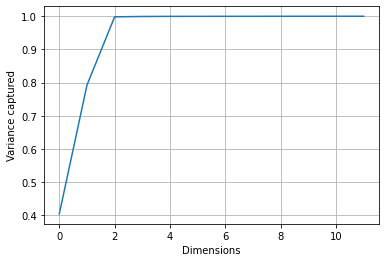

In [127]:
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Variance captured")
plt.grid(True)

In [128]:
pca = PCA(n_components = d)
X_func_pos_LAbody_fit = pca.fit_transform(X_func_pos_LAbody)

In [129]:
pca.explained_variance_ratio_

array([0.40390479, 0.3883554 , 0.20593689])

### Visualise the data in the PCs

In [130]:
X_func_LAbody_fit.shape

(134028, 7)

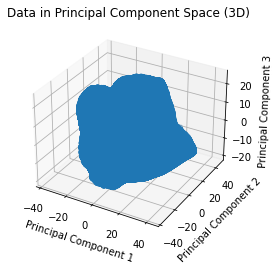

In [131]:
# Create a 3D scatter plot of the principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_func_pos_LAbody_fit[:, 0], X_func_pos_LAbody_fit[:, 1], X_func_pos_LAbody_fit[:, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')
plt.show()

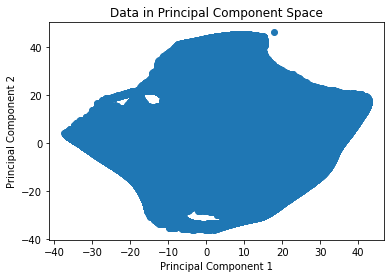

In [132]:
# Visualize in PC 1 and 2
plt.scatter(X_func_pos_LAbody_fit[:, 0], X_func_pos_LAbody_fit[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data in Principal Component Space')
plt.show()

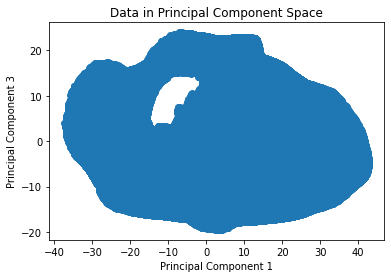

In [133]:
# Visualize in PC 1 and 3
plt.scatter(X_func_pos_LAbody_fit[:, 0], X_func_pos_LAbody_fit[:, 2])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Data in Principal Component Space')
plt.show()

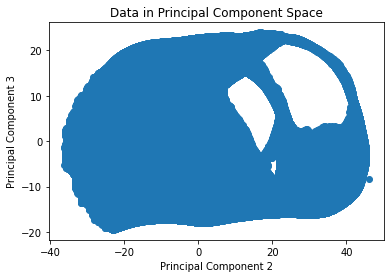

In [134]:
# Visualize in PC 2 and 3
plt.scatter(X_func_pos_LAbody_fit[:, 1], X_func_pos_LAbody_fit[:, 2])
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Data in Principal Component Space')
plt.show()

There appears to be ?? distinct clusters from the PCA using strains + positions as the features.

Let's verify this using KMeans clustering, giving each data instance a cluster index.

### And so begins the shitshow of choosing the number of clusters to use in KMeans

In [135]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_func_pos_LAbody_fit)

In [136]:
centroids=kmeans.cluster_centers_

In [137]:
centroids

array([[ 28.89430325,   1.90589747,  -4.67332644],
       [-22.35506423,  -0.05044144,  -3.33529591],
       [ -0.87924453,  29.73838789,  -2.96127386],
       [  2.51219077,  -2.78686016,  19.07196767],
       [  2.70513703, -21.19651611,  -7.23757798]])

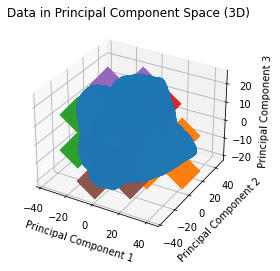

In [138]:
# Create a 3D scatter plot of the principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_func_pos_LAbody_fit[:, 0], X_func_pos_LAbody_fit[:, 1], X_func_pos_LAbody_fit[:, 2])

for i in range(5):
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='X', s=5000)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')
plt.show()

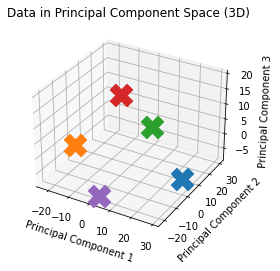

In [139]:
# Create a 3D scatter plot of the principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_func_pos_LAbody_fit[:, 0], X_func_pos_LAbody_fit[:, 1], X_func_pos_LAbody_fit[:, 2])

for i in range(5):
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='X', s=500)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')
plt.show()

In [140]:
silhouette_score(X_func_pos_LAbody_fit, kmeans.labels_)

0.32785931856650213

### Calculate Silhouette Score for different numbers of clusters

In [141]:
silh_scores=np.zeros((5,))

for i in range(2, 7):
    print("Doing ", i)

    k = i
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X_func_pos_LAbody_fit)
    
    ans=silhouette_score(X_func_pos_LAbody_fit, kmeans.labels_)
    print(f"Number of clusters: {k}\t\tSilhouette score: {ans}")
    
    silh_scores[i-2]=ans

Doing  2
Number of clusters: 2		Silhouette score: 0.2947325081449817
Doing  3
Number of clusters: 3		Silhouette score: 0.3245280034203856
Doing  4
Number of clusters: 4		Silhouette score: 0.30717298715155716
Doing  5
Number of clusters: 5		Silhouette score: 0.327606232392193
Doing  6
Number of clusters: 6		Silhouette score: 0.3456904770803347


In [85]:
cond_3=kmeans.labels_==3

In [86]:
kmeans.labels_.shape

(65254,)

In [89]:
X_func_pos_LAbody_fit[cond_3]

array([[54.95644591, -1.06664286, 17.76312478],
       [55.36378112, -4.4399465 , 15.94930869],
       [54.63463298,  1.38965312, 17.69751598],
       ...,
       [51.1411673 , -4.80210371,  4.64197364],
       [51.10463666, -4.75623461,  4.50706468],
       [51.11345692, -4.86656476,  4.61615659]])

### Take N_Clusters=5 Just for Bants to Visualise on the anatomy

In [91]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_func_pos_LAbody_fit)

In [93]:
np.sum(condition)

pyvista_ndarray(65254)

In [95]:
np.unique(y_pred)

array([0, 1, 2, 3, 4], dtype=int32)

In [103]:
y_pred = y_pred + 1

In [104]:
np.unique(y_pred)

array([1, 2, 3, 4, 5], dtype=int32)

In [105]:
cluster_data_to_apnd=np.zeros((msh.n_cells,))

In [106]:
cluster_data_to_apnd[condition] = y_pred

In [107]:
msh.cell_data["Cluster_k5"] = cluster_data_to_apnd

In [108]:
path2msh

'/home/csi20local/Dropbox/phd/Data/RG_CT_Cases/CT-CRT/case05/MT-HiRes/SW-0.0-BE-1e-9/cLr-fibres-aligned-4.vtp'

In [109]:
msh.save("/home/csi20local/Dropbox/phd/Data/RG_CT_Cases/CT-CRT/case05/MT-HiRes/SW-0.0-BE-1e-9/cLr-fibres-aligned-4-clstr.vtp")

In [ ]:
kmeans.cluster_centers_

In [ ]:
# Create a 3D scatter plot of the principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2D[:, 0], X2D[:, 1], X2D[:, 2])

centroids=kmeans.cluster_centers_
for i in range(3):
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='X', s=400)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')
plt.show()

In [ ]:
# Create a 3D scatter plot of the principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

centroids=kmeans.cluster_centers_
for i in range(3):
    ax.scatter(centroids[i, 0], centroids[i, 1], centroids[i, 2], marker='X', s=400)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Data in Principal Component Space (3D)')

plt.show()

In [ ]:
condition = X2D[:, 2] > 150

In [ ]:
np.sum(condition)

In [ ]:
np.argmax(X2D[:, 2])

In [ ]:
X2D[376, :]